<a href="https://colab.research.google.com/github/HighCWu/anime_biggan_toy/blob/main/colab/AnimeBigGAN_tf2hub_fast.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Download Model

In [ ]:
!rsync --verbose --progress rsync://78.46.86.149:873/biggan/2020-05-18-spresser-biggan-256px-danbooruplus-run39-607250.tar.xz ./

In [ ]:
!tar -xf 2020-05-18-spresser-biggan-256px-danbooruplus-run39-607250.tar.xz

In [ ]:
!cp 2020-05-18-spresser-biggan-256px-danbooruplus-run39-607250 drive/My\ Drive/ -r

## Restore Model And Convert To TFHUB

In [1]:
!pip install mock
!git clone https://github.com/HighCWu/compare_gan
!cd compare_gan && git checkout easyhub
!cd compare_gan && pip install -e .
!cp drive/My\ Drive/2020-05-18-spresser-biggan-256px-danbooruplus-run39-607250 ./compare_gan/ -r

Cloning into 'compare_gan'...
remote: Enumerating objects: 2513, done.
remote: Total 2513 (delta 0), reused 0 (delta 0), pack-reused 2513
Receiving objects: 100% (2513/2513), 1.21 MiB | 24.33 MiB/s, done.
Resolving deltas: 100% (1845/1845), done.
Branch 'easyhub' set up to track remote branch 'easyhub' from 'origin'.
Switched to a new branch 'easyhub'
Obtaining file:///content/compare_gan
     |████████████████████████████████| 51kB 6.6MB/s 
     |████████████████████████████████| 409kB 9.7MB/s 
     |████████████████████████████████| 153kB 41.4MB/s 
     |████████████████████████████████| 51kB 8.5MB/s 
  Found existing installation: gin-config 0.3.0
    Uninstalling gin-config-0.3.0:
      Successfully uninstalled gin-config-0.3.0
  Found existing installation: tensorflow-datasets 2.1.0
    Uninstalling tensorflow-datasets-2.1.0:
      Successfully uninstalled tensorflow-datasets-2.1.0
  Running setup.py develop for compare-gan


In [2]:
import os
os.chdir('compare_gan')

In [3]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [4]:
# ModularGAN extend build_graph fn
import tensorflow as tf
from compare_gan.gans.modular_gan import ModularGAN


def build_graph(self, model=None):
    batch_size = None
    is_training = False
    y_gen, y_disc = None, None
    inputs_gen, inputs_disc = {}, {}
    outputs_gen, outputs_disc = {}, {}
    inputs_gen["z"] = None if model=='disc' else tf.placeholder(
        shape=(batch_size, self._z_dim),
        dtype=tf.float32,
        name="z_for_eval"
    )
    inputs_disc["images"] = None if model=='gen' else tf.placeholder(
        shape=[batch_size] + list(self._dataset.image_shape),
        dtype=tf.float32,
        name="images_for_eval"
    )
    if self.conditional:
        inputs_gen["labels"] = None if model=='disc' else tf.placeholder(
            shape=(batch_size,),
            dtype=tf.int32,
            name="labels_for_gen_eval"
        )
        y_gen = None if model=='disc' else self._get_one_hot_labels(inputs_gen["labels"])
        inputs_disc["labels"] = None if model=='gen' else tf.placeholder(
            shape=(batch_size,),
            dtype=tf.int32,
            name="labels_for_disc_eval"
        )
        y_disc = None if model=='gen' else self._get_one_hot_labels(inputs_disc["labels"])
    else:
      y_gen, y_disc = None, None

    outputs_disc["prediction"], _, _ = (None,None,None) if model=='gen' else self.discriminator(
        inputs_disc["images"], y=y_disc, is_training=is_training
    )

    z = inputs_gen["z"]
    generated = None if model=='disc' else self.generator(z=z, y=y_gen, is_training=is_training)
    if self._g_use_ema and model != 'disc':
        g_vars = [var for var in tf.trainable_variables()
              if "generator" in var.name]
        ema = tf.train.ExponentialMovingAverage(decay=self._ema_decay)
        # Create the variables that will be loaded from the checkpoint.
        ema.apply(g_vars)
        def ema_getter(getter, name, *args, **kwargs):
            var = getter(name, *args, **kwargs)
            ema_var = ema.average(var)
            if ema_var is None:
                var_names_without_ema = {"u_var", "accu_mean", "accu_variance",
                              "accu_counter", "update_accus"}
                if name.split("/")[-1] not in var_names_without_ema:
                    print("Could not find EMA variable for %s.", name)
                return var
            return ema_var
        with tf.variable_scope("", values=[z, y_gen], reuse=True, custom_getter=ema_getter):
            ema_generated = self.generator(z, y=y_gen, is_training=is_training)
            if not is_training:
                generated = ema_generated
    outputs_gen["generated"] = None if model=='disc' else generated
    return {
        "gen": {
            "inputs": inputs_gen, 
            "outputs": outputs_gen
        },
        "disc": {
            "inputs": inputs_disc,
            "outputs": outputs_disc
        }
    }
ModularGAN.build_graph = build_graph




The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.




In [5]:
import os
import gin
import tensorflow as tf
import tensorflow_hub as hub
from compare_gan import main, runner_lib, datasets
from compare_gan.gans import utils, modular_gan
from compare_gan.gans.modular_gan import ModularGAN

os.environ["NUM_CORES"] = '8'
gin.parse_config_file('example_configs/bigrun40.gin')
gin.bind_parameter("standardize_batch.use_cross_replica_mean", False)
src_model_path = '2020-05-18-spresser-biggan-256px-danbooruplus-run39-607250/'

use_ema = True

class FakeDataset:
    num_classes = 1000
    random_labels = True
    image_shape = (256, 256, 3)


model = ModularGAN(FakeDataset, {
        "architecture": "resnet_biggan_arch",
        "z_dim": 140,
        "lambda": 1,
    }, src_model_path, g_use_ema=use_ema
)

In [6]:
import os
import itertools
import numpy as np
from PIL import Image
from compare_gan.architectures import arch_ops
arch_ops.use_assign_forbidden = False

os.makedirs('accu_samples', exist_ok=True)

batch_size = 4
num_accu_steps = 100 # a few steps and accu all levels together
export_path = os.path.join('anime-biggan-256px-run39-607250', "tfhub")
checkpoint_path = os.path.join('anime-biggan-256px-run39-607250-tmp', "model.ckpt")
tf.keras.backend.clear_session()


with tf.Session() as sess:
    inout_nodes = model.build_graph()
    inout_gen, inout_disc = inout_nodes["gen"], inout_nodes["disc"]
    init_op = tf.group(tf.global_variables_initializer(),tf.local_variables_initializer())
    sess.run(init_op)
    saver = tf.train.Saver()
    saver.restore(sess, src_model_path + 'model.ckpt-607250')
    update_accu_switches = [v for v in tf.global_variables()
                 if "accu/update_accus" in v.name]
    def run_model():
        z = rng.randn(batch_size, model._z_dim).astype(np.float32)
        if not model.conditional:
            _z = inout_gen['inputs']['z']
            images = sess.run(inout_gen['outputs']['generated'], feed_dict={_z: z})
        else:
            y = rng.randint(model._dataset.num_classes, size=(batch_size, )).astype(np.int32)
            _z = inout_gen['inputs']['z']
            _y_gen = inout_gen['inputs']['labels']
            images = sess.run(inout_gen['outputs']['generated'], feed_dict={_z: z, _y_gen: y})
        return images
    for j, update_accu in enumerate(update_accu_switches):
        sess.run(tf.assign(update_accu, 1))

    rng = np.random.RandomState(0)
    for i in range(num_accu_steps):
        images = run_model()
        dst_filename = f'accu_samples/batchsize_{batch_size}.png'
        image = Image.fromarray(np.uint8(images.transpose((1,0,2,3)).reshape((256,-1,3)).clip(0,1) * 255))
        image.save(f'accu_samples/batchsize_{batch_size}_accu_{str(i+1).zfill(5)}.png')
        print(f'Updating BN accumulators {str(i+1).zfill(5)}/{str(num_accu_steps).zfill(5)} steps.')
    
    for j, update_accu in enumerate(update_accu_switches):
        sess.run(tf.assign(update_accu, 0))
    
    rng = np.random.RandomState(0)
    images = run_model()
    dst_filename = f'accu_samples/batchsize_{batch_size}.png'
    image = Image.fromarray(np.uint8(images.transpose((1,0,2,3)).reshape((256,-1,3)).clip(0,1) * 255))
    image.save(dst_filename)
    print('Done updating BN accumulators.')

    saver = tf.train.Saver()
    saver.save(sess, checkpoint_path)


Instructions for updating:
Use keras.layers.MaxPooling2D instead.


Instructions for updating:
Use keras.layers.MaxPooling2D instead.


Instructions for updating:
Please use `layer.__call__` method instead.


Instructions for updating:
Please use `layer.__call__` method instead.


Instructions for updating:
Use Variable.read_value. Variables in 2.X are initialized automatically both in eager and graph (inside tf.defun) contexts.


Instructions for updating:
Use Variable.read_value. Variables in 2.X are initialized automatically both in eager and graph (inside tf.defun) contexts.


INFO:tensorflow:Restoring parameters from 2020-05-18-spresser-biggan-256px-danbooruplus-run39-607250/model.ckpt-607250


INFO:tensorflow:Restoring parameters from 2020-05-18-spresser-biggan-256px-danbooruplus-run39-607250/model.ckpt-607250


Updating BN accumulators 00001/00100 steps.
Updating BN accumulators 00002/00100 steps.
Updating BN accumulators 00003/00100 steps.
Updating BN accumulators 00004/00100 steps.
Updating BN accumulators 00005/00100 steps.
Updating BN accumulators 00006/00100 steps.
Updating BN accumulators 00007/00100 steps.
Updating BN accumulators 00008/00100 steps.
Updating BN accumulators 00009/00100 steps.
Updating BN accumulators 00010/00100 steps.
Updating BN accumulators 00011/00100 steps.
Updating BN accumulators 00012/00100 steps.
Updating BN accumulators 00013/00100 steps.
Updating BN accumulators 00014/00100 steps.
Updating BN accumulators 00015/00100 steps.
Updating BN accumulators 00016/00100 steps.
Updating BN accumulators 00017/00100 steps.
Updating BN accumulators 00018/00100 steps.
Updating BN accumulators 00019/00100 steps.
Updating BN accumulators 00020/00100 steps.
Updating BN accumulators 00021/00100 steps.
Updating BN accumulators 00022/00100 steps.
Updating BN accumulators 00023/0

In [7]:
tf.keras.backend.clear_session()
from compare_gan.architectures import arch_ops
arch_ops.use_assign_forbidden = True

def model_fn(model_type):
    inout_nodes = model.build_graph(model_type)
    inout_gen, inout_disc = inout_nodes["gen"], inout_nodes["disc"]
    if model_type == 'gen' or model_type is None:
        hub.add_signature(inputs=inout_gen['inputs'], outputs=inout_gen['outputs'])
    else:
        hub.add_signature(inputs=inout_disc['inputs'], outputs=inout_disc['outputs'])
tags_and_args = [
    (set(), {"model_type": None}),
    ({"gen", "bsNone"}, { "model_type": "gen" }),
    ({"disc", "bsNone"}, { "model_type": "disc" })]
module_spec = hub.create_module_spec(
    model_fn, tags_and_args=tags_and_args,
    drop_collections=[tf.GraphKeys.MOVING_AVERAGE_VARIABLES]
)

module_spec.export(export_path, checkpoint_path=checkpoint_path)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
This function will only be available through the v1 compatibility library as tf.compat.v1.saved_model.utils.build_tensor_info or tf.compat.v1.saved_model.build_tensor_info.


Instructions for updating:
This function will only be available through the v1 compatibility library as tf.compat.v1.saved_model.utils.build_tensor_info or tf.compat.v1.saved_model.build_tensor_info.


In [8]:
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
from PIL import Image
from IPython.display import display

export_path = os.path.join('anime-biggan-256px-run39-607250', "tfhub")

tf.keras.backend.clear_session()

# Load module.
module = hub.Module(export_path)

batch_size = 4
z_dim = 140

# Sample random noise (z) and ImageNet label (y) inputs.
z = tf.random.normal(shape=[batch_size, z_dim],stddev=1.0, seed=0)  # noise sample
labels = tf.random.uniform([batch_size], maxval=1000, dtype=tf.int32, seed=0)
inputs = dict(z=z, labels=labels)

sess = tf.Session()
samples = module(inputs, as_dict=True)
init_op = tf.group(tf.global_variables_initializer(),tf.local_variables_initializer())
sess.run(init_op)

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


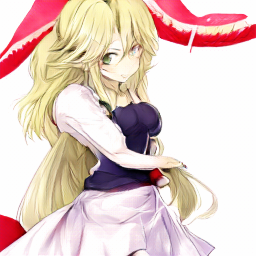

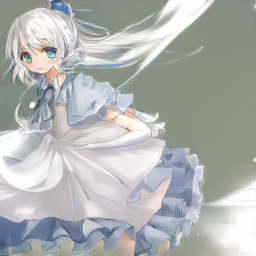

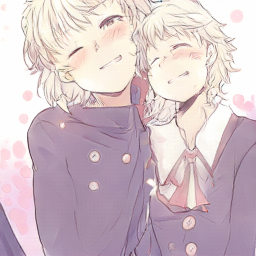

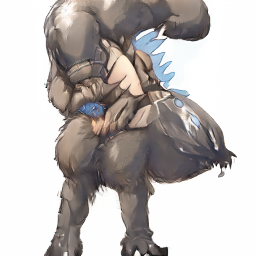

In [9]:
ret = sess.run(samples)['generated']
for it in ret:
    display(Image.fromarray(np.uint8(it.clip(0,1)*255)))

In [ ]:
# !cp anime-biggan-256px-run39-607250 ../drive/My\ Drive/ -r

## Interpolate Exp

In [10]:
!mkdir data -p

In [11]:
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
from PIL import Image
from IPython.display import display

export_path = os.path.join('anime-biggan-256px-run39-607250', "tfhub")

tf.keras.backend.clear_session()

# Load module.
module = hub.Module(export_path)

batch_size = None
z_dim = 140

z = tf.placeholder(shape=[batch_size, z_dim],dtype=tf.float32,name="z_for_eval")
labels = tf.placeholder(shape=[batch_size,],dtype=tf.int32,name="labels_for_gen_eval")
inputs = dict(z=z, labels=labels)

sess = tf.Session()
samples = module(inputs, as_dict=True)
init_op = tf.group(tf.global_variables_initializer(),tf.local_variables_initializer())
sess.run(init_op)

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [16]:
import os
import numpy as np
from PIL import Image

from sys import stdout

class RandomState(object):
    rng = None
rds = RandomState

def std_gen(batch_size=8, seed=None):
    if seed is not None:
        rds.rng = np.random.RandomState(seed)
    elif rds.rng is None:
        rds.rng = np.random
    x_np = rds.rng.randn(batch_size,140).astype('float32')
    y_np = rds.rng.randint(0,1000,size=[batch_size]).astype('int32')
    img = sess.run(samples, feed_dict={z: x_np, labels: y_np})['generated']
    img = np.uint8(img.clip(0,1)*255)
    imgs = []
    for i in range(len(img)):
        imgs += [Image.fromarray(img[i])]
    return imgs

def std_gen_interpolate(batch_size=8, seed=None, out_path='data/out.mp4', levels=None, interpolate_mode=0):
    default_levels = ("z0;z1;z2;z3;z4;z5;z6")
    if levels is None:
        levels = default_levels
    default_levels = default_levels.split(';')

    img_save_dir = os.path.join('/tmp', out_path+'.dir')
    !rm -rf $img_save_dir
    !mkdir $img_save_dir -p
    if seed is not None:
        rds.rng = np.random.RandomState(seed)
    elif rds.rng is None:
        rds.rng = np.random
    x_np = rds.rng.randn(batch_size,140).astype('float32')
    y_np = rds.rng.randint(0,1000,size=[batch_size]).astype('int32')[:1] # use the same class because it's not easy to crack the model inner
    x_np = np.concatenate([x_np, x_np[:1]], 0)
    levels = levels.split(';')
    for level in default_levels:
        if len(level) >= 2:
            idx = int(level[1])*20
            locals()[level] = x_np[:,idx:idx+20]
            locals()['_'+level] = x_np[:1,idx:idx+20]
    imgs = []
    for i in range(batch_size):
        for j in range(40):
            alpha = j / 40
            if interpolate_mode == 1:
                alpha = alpha**2 * (3 - 2 * alpha)
            for level in levels:
                locals()['_'+level] = (1 - alpha) *  locals()[level][i:i+1] + alpha * locals()[level][i+1:i+2]
            inputs = []
            for level in default_levels:
                inputs.append(locals()['_'+level])
            inputs = np.concatenate(inputs, 1)
            img = sess.run(samples, feed_dict={z: inputs, labels: y_np})['generated']
            img = np.uint8(img.clip(0,1)*255)[0]
            imgs.append(Image.fromarray(img))
            stdout.write(f'{i*40+j+1}/{40*batch_size}\r')
            stdout.flush()
    print('')
    for i, img in enumerate(imgs):
        img.save(os.path.join(img_save_dir, str(i).zfill(5)+'.png'))
    imgs[0].save(out_path+'.gif', save_all=True, append_images=imgs[1:], duration=40, loop=0)
    out_path = out_path + '.mp4'
    os.system(f'ffmpeg -r 40 -i {img_save_dir}/%05d.png -hide_banner -loglevel warning -nostats -c:v libx264 -crf 23 -y {out_path}')
    os.system(f'rm -rf {img_save_dir}')

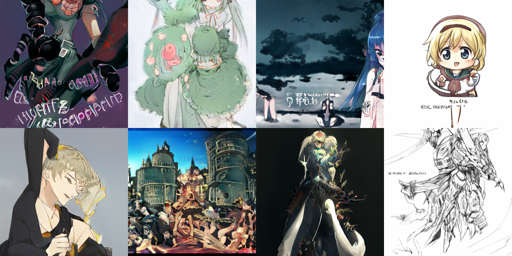

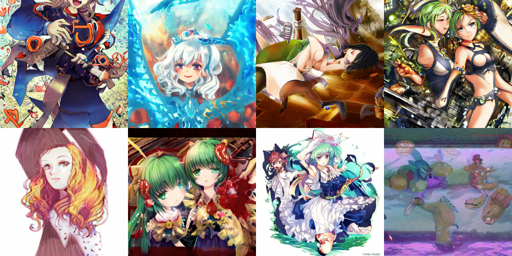

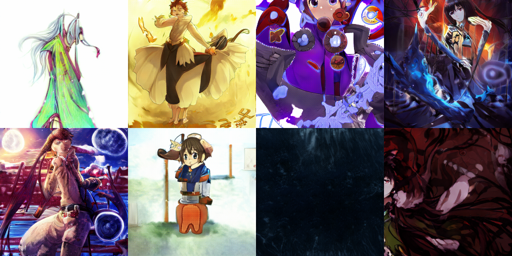

In [14]:
# 运行模型的标准生成输出过程 Run Output Process of Model's Standard Generation 
import numpy as np
from PIL import Image
from IPython.display import display

def concat_imgs_bsz8(imgs):
    np_imgs = [np.asarray(img) for img in imgs]
    img1 = np.concatenate(np_imgs[:4], 1)
    img2 = np.concatenate(np_imgs[4:], 1)
    img = Image.fromarray(np.concatenate([img1, img2], 0))
    return img.resize([img.size[0]//2, img.size[1]//2])

imgs = std_gen(8, seed=233)
for i, img in enumerate(imgs):
    img.save(f'data/std_seed233_{str(i).zfill(3)}.png')
display(concat_imgs_bsz8(imgs))

imgs = std_gen(8, seed=None)
for i, img in enumerate(imgs):
    img.save(f'data/std_seed233_{str(i+8).zfill(3)}.png')
display(concat_imgs_bsz8(imgs))

imgs = std_gen(8, seed=234) # 不同的seed不同的结果 Different seed with different result
for i, img in enumerate(imgs):
    img.save(f'data/std_seed234_{str(i).zfill(3)}.png')
display(concat_imgs_bsz8(imgs))

In [17]:
# 运行模型的标准生成动图输出过程 Run Gif Output Process of Model's Standard Generation 
from IPython.display import display, HTML

from IPython.display import HTML

def display_mp4(path):
    print(f'Read from {path}')
    from base64 import b64encode
    mp4 = open(path,'rb').read()
    data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
    display(HTML("""
    <video controls loop autoplay>
        <source src="%s" type="video/mp4">
    </video>
    """ % data_url))
    print('Display finished.')

std_gen_interpolate(8, seed=233, out_path='data/std_out1', interpolate_mode=1)
std_gen_interpolate(8, seed=None, out_path='data/std_out2', interpolate_mode=0)
std_gen_interpolate(8, seed=234, out_path='data/std_out3', interpolate_mode=1) # 不同的seed不同的结果 Different seed with different result

In [18]:
# display(HTML('<img src="data/std_out1.gif">'))
# display(HTML('<img src="data/std_out2.gif">'))
# display(HTML('<img src="data/std_out3.gif">'))

# display_mp4("data/std_out1.mp4")
display_mp4("data/std_out2.mp4")
# display_mp4("data/std_out3.mp4")

Read from data/std_out2.mp4


Display finished.


In [20]:
# 运行模型的标准生成分层插值动图输出过程 Run Gif Output Process of Model's Standard Generation 
from IPython.display import display, HTML

def display_mp4(path):
    print(f'Read from {path}')
    from base64 import b64encode
    mp4 = open(path,'rb').read()
    data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
    display(HTML("""
    <video controls loop autoplay>
        <source src="%s" type="video/mp4">
    </video>
    """ % data_url))
    print('Display finished.')

std_gen_interpolate(8, seed=2333, out_path='data/std_inter1', levels="z1")
std_gen_interpolate(8, seed=2333, out_path='data/std_inter2', levels="z2")
std_gen_interpolate(8, seed=2333, out_path='data/std_inter3', levels="z3")
std_gen_interpolate(8, seed=2333, out_path='data/std_inter4', levels="z4")
std_gen_interpolate(8, seed=2333, out_path='data/std_inter5', levels="z5")
std_gen_interpolate(8, seed=2333, out_path='data/std_inter6', levels="z6")

In [21]:
# display(HTML('<img src="data/std_inter1.gif">'))
# display(HTML('<img src="data/std_inter2.gif">'))
# display(HTML('<img src="data/std_inter3.gif">'))
# display(HTML('<img src="data/std_inter4.gif">'))
# display(HTML('<img src="data/std_inter5.gif">'))
# display(HTML('<img src="data/std_inter6.gif">'))

# display_mp4("data/std_inter1.mp4")
# display_mp4("data/std_inter2.mp4")
# display_mp4("data/std_inter3.mp4")
display_mp4("data/std_inter4.mp4")
# display_mp4("data/std_inter5.mp4")
# display_mp4("data/std_inter6.mp4")

Read from data/std_inter4.mp4


Display finished.
